# Camera calibration notebook

This notebook is used to calibrate the camera and save the calibration parameters
to an opencv file. The calibration parameters are used in the main notebook to
undistort the images.

The first input box defines input parameters for all of the procedure. Be sure to
set the correct path to the calibration video, the number of chessboard corners
for the pattern it was used, and the length of the chessboard squares in cm.

In [33]:
%matplotlib widget

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from moviepy.editor import VideoFileClip


In [34]:
videoPath = "../data/videos/2016_0718_200947_002.MOV"  # input video path
cornerDataPath = "../data/corners.npy"  # output path for the corner data, in case we want to redo only calibration without having to detect corners
calibrationDataPath = "../data/calibration.xml"  # output path for the calibration data
readExistingCornerData = False  # if True, read corner data from cornerDataPath, otherwise detect corners from video

patternSize = (8, 6)  # number of corners in the calibration pattern (rows, columns)
subPixWinSize = (5, 5)  # depends on the resolution, 5, 5 seems ok for this camera resolution

patternSquareSideLength = 1.6  # length of pattern square side in cm
skipFrames = 120  # how many frames do we skip while seeking video for calibration shots
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


In [35]:
"""
Open the video stream, and fetch needed metadata for futher processing.
"""

video = VideoFileClip(videoPath)

numFrames = int(video.fps * video.duration)

In [36]:
"""
Reading video frames, and detecting the chessboard pattern in them.
"""

validFrames = []
allCorners = []  # collection of all corners for calibration purposes

if not readExistingCornerData:

    # Enable interactive mode
    for frame_id in tqdm(range(0, numFrames, skipFrames)):
        frame = video.get_frame(float(frame_id) / video.fps)

        # convert to grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        quitReading = False

        # try detecting the chart
        patternWasFound, corners = cv2.findChessboardCorners(frame, patternSize, cv2.CALIB_CB_FAST_CHECK)

        if patternWasFound:
            corners = cv2.cornerSubPix(frame, corners, subPixWinSize, (-1, -1), criteria)
            allCorners.append(corners)
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            cv2.drawChessboardCorners(frame_bgr, patternSize, corners, patternWasFound)

            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            validFrames.append(frame)

    allCorners = np.array(allCorners)
    np.save(cornerDataPath, allCorners)

    print("Saved corners to {}".format(cornerDataPath))
else:
    allCorners = np.load(cornerDataPath)

numSamples = allCorners.shape[0]
print("Collected {} corner sampels.".format(numSamples))

  0%|          | 0/69 [00:00<?, ?it/s]

Saved corners to ../data/corners.npy
Collected 40 corner sampels.


In [37]:
"""
Setting up the object points we need for calibration.
"""
objPoints = np.zeros((patternSize[0]*patternSize[1], 3), np.float32)
objPoints[:, :2] = np.mgrid[0:patternSize[0], 0:patternSize[1]].T.reshape(-1, 2).astype(np.float32)
objPoints *= patternSquareSideLength

# Assuming `objPoints` is a list of lists or a list of arrays
# First, convert it to a numpy array
objPoints = np.array([objPoints] * numSamples)

objPoints = np.reshape(objPoints, (numSamples, objPoints[0].shape[0], 1, 3))

# Then, convert it to a 3-channel float32 array if it's not already
if objPoints.dtype != np.float32 or objPoints.shape[-1] != 3:
    objPoints = objPoints.astype(np.float32)


In [38]:
"""
Finally, we run the calibration.
"""

frameSize = validFrames[0].shape[::-1]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, allCorners, frameSize, None, None)

if ret:
    print("Matrix:\n{}".format(mtx))
    print("Distortion:\n{}".format(dist))

    storage = cv2.FileStorage(calibrationDataPath, cv2.FILE_STORAGE_WRITE)
    storage.write("mtx", mtx)
    storage.write("dist", dist)
    storage.release()
else:
    assert False, "Calibration failed"


Matrix:
[[673.45343995   0.         623.14831056]
 [  0.         682.79329868 352.97952315]
 [  0.           0.           1.        ]]
Distortion:
[[-0.30753066  0.14322415  0.00157635 -0.00496722 -0.04151598]]


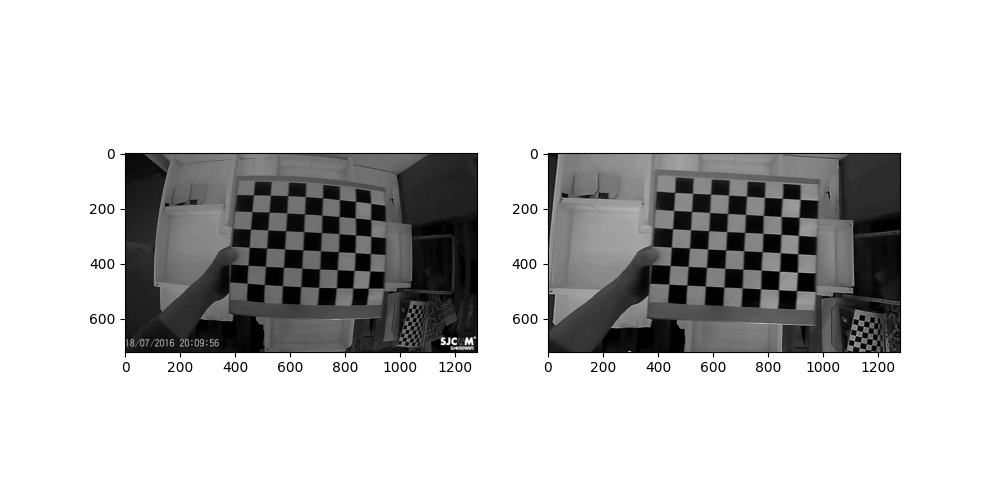

In [39]:
"""
Finally let's undistor an image sample and display it side by side with the original, to make sure our distorition coefficients are correctly estimated.
"""

# Assuming you have an image stored in the variable `img`
original_img = validFrames[0].copy()

# Compute the undistortion and rectification transformation map
undistorted_img = cv2.undistort(original_img, mtx, dist)

# show undistorted image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_img, cmap="gray")
ax[1].imshow(undistorted_img, cmap="gray")

plt.show()